In [4]:
!pip install pandas

   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ------ --------------------------------- 1.8/11.5 MB 10.0 MB/s eta 0:00:01
   -------------- ------------------------- 4.2/11.5 MB 10.5 MB/s eta 0:00:01
   --------------------- ------------------ 6.3/11.5 MB 10.2 MB/s eta 0:00:01
   ----------------------------- ---------- 8.4/11.5 MB 10.2 MB/s eta 0:00:01
   ----------------------------------- ---- 10.2/11.5 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 10.0 MB/s eta 0:00:00


In [5]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

# Lectura de datos

In [19]:
efective_experiments = [36]
drain_current = list()
ds_voltage = list()
ds_transient_voltage = list()
ds_transient_current = list()
time_open = list()
temperature = list()
time = list()
init = True

for experiment in efective_experiments:
    # Cargar el archivo .mat
    mat_data = scipy.io.loadmat(f'../MOSFET_Thermal_Overstress_Aging_v0/Test_{experiment}_run_1.mat', squeeze_me=True, struct_as_record=False)

    # Acceder al struct 'measurement'
    measurement = mat_data['measurement']

    pwm = measurement.pwmTempControllerState
    for i in range(len(pwm)):
        if pwm[i].gateState == 1:
            t_open = datetime.strptime(pwm[i].time, '%m/%d/%Y %H:%M:%S.%f').timestamp()
            try:
                t_close = datetime.strptime(pwm[i+1].time, '%m/%d/%Y %H:%M:%S.%f').timestamp()
            except IndexError:
                t_close = float('inf')

            time_open.append((t_open,t_close))
        
    print(f"Tiempo abierto: {time_open}")





    # Acceder al campo 'steady'
    steady = measurement.steadyState 


    
    for measure in steady:
        
        fecha_dt = datetime.strptime(measure.date, '%m/%d/%Y %H:%M:%S.%f').timestamp()
        time.append(fecha_dt)

        # Leer corriente del drain 
        drain_current_n = measure.timeDomain.drainCurrent
        drain_current.append(drain_current_n)

        # Leer voltaje drain-source

        ds_voltage_n = measure.timeDomain.drainSourceVoltage
        ds_voltage.append(ds_voltage_n)

        # Leer Temperatura
    df = pd.DataFrame({'time': time[2200:], 'drain_current': drain_current[2200:], 'ds_voltage': ds_voltage[2200:] })
    dfs = [df[(df["time"] >= start) & (df["time"] <= end)] for start, end in time_open]
    filtered_df = pd.concat(dfs).sort_index()
    

    
    print(len(time))
    print(len(drain_current))
    print(len(ds_voltage))

Tiempo abierto: [(1282342938.978, 1282342942.578), (1282342943.009, 1282342947.008), (1282342947.435, 1282342952.635), (1282342953.06, 1282342959.86), (1282342960.29, 1282342968.17), (1282342968.598, 1282342977.398), (1282342977.827, 1282342987.426), (1282342987.853, 1282342997.453), (1282342997.889, 1282343003.794), (1282343008.718, 1282343009.918), (1282343010.749, 1282343012.349), (1282343013.578, 1282343015.977), (1282343016.81, 1282343018.81), (1282343019.636, 1282343022.036), (1282343022.867, 1282343025.267), (1282343026.096, 1282343028.896), (1282343029.725, 1282343032.925), (1282343033.766, 1282343036.983), (1282343037.812, 1282343041.012), (1282343041.841, 1282343045.441), (1282343046.272, 1282343049.872), (1282343050.701, 1282343054.301), (1282343055.129, 1282343058.729), (1282343059.561, 1282343063.561), (1282343064.389, 1282343067.989), (1282343068.416, 1282343068.482), (1282343073.319, 1282343074.52), (1282343075.747, 1282343076.947), (1282343078.175, 1282343079.775), (128

# Graficos

Normalización de la resistencia y se cambia la escala de tiempo para que parta en 0.

Text(0, 0.5, 'R_ds (normalized)')

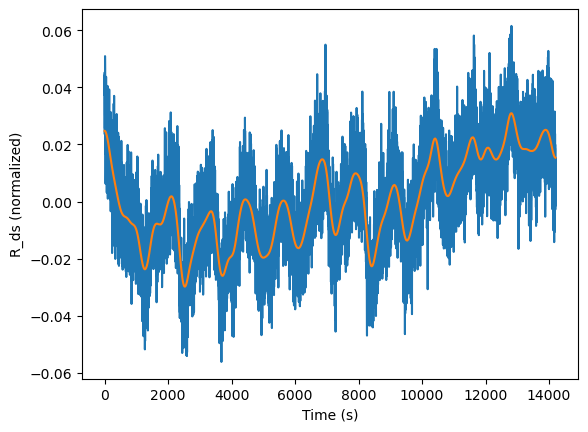

In [20]:
filtered_df["R_ds"] = filtered_df["ds_voltage"] / filtered_df["drain_current"]
R_init = filtered_df["R_ds"].iloc[0]
R_mean = filtered_df["R_ds"].mean()


time_init = filtered_df["time"].iloc[0]

filtered_df["time"] = filtered_df["time"].apply(lambda x: x - time_init)
filtered_df["R_ds"] = filtered_df["R_ds"].apply(lambda x: x - R_mean)
filtered_df["R_ds"] = filtered_df["R_ds"].apply(lambda x: x/ R_mean)
plt.plot(filtered_df["time"], filtered_df["R_ds"])


# Apply gaussian filter to the data
from scipy.ndimage import gaussian_filter1d

filtered_df["R_ds"] = gaussian_filter1d(filtered_df["R_ds"], sigma=100)
plt.plot(filtered_df["time"], filtered_df["R_ds"])
plt.xlabel("Time (s)")
plt.ylabel("R_ds (normalized)")

# Codigos por si acaso

In [ ]:
for experiment in efective_experiments:
    # Cargar el archivo .mat
    mat_data = scipy.io.loadmat(f'MOSFET_Thermal_Overstress_Aging_v0/Test_{experiment}_run_1.mat', squeeze_me=True, struct_as_record=False)

    # Acceder al struct 'measurement'
    measurement = mat_data['measurement']

    # Acceder al campo 'steady'
    steady = measurement.steadyState 
    transient = measurement.transient
    print(transient[0].timeDomain.drainSourceVoltage )
    for measure in steady:
        if init:
            init_time = datetime.strptime(measure.date, '%m/%d/%Y %H:%M:%S.%f').timestamp()
            init = False
        fecha_dt = datetime.strptime(measure.date, '%m/%d/%Y %H:%M:%S.%f').timestamp()
        time.append((fecha_dt-init_time)/60)

        # Leer corriente del drain 
        drain_current_n = measure.timeDomain.drainCurrent
        drain_current.append(drain_current_n)

        # Leer voltaje drain-source

        ds_voltage_n = measure.timeDomain.drainSourceVoltage
        ds_voltage.append(ds_voltage_n)


In [ ]:
# Antes de hacer la concatenacion de datframes

    # Acceder al campo 'steady'
    steady = measurement.steadyState 


    
    for measure in steady:
        if init:
            init_time = datetime.strptime(measure.date, '%m/%d/%Y %H:%M:%S.%f').timestamp()
            init = False
        fecha_dt = datetime.strptime(measure.date, '%m/%d/%Y %H:%M:%S.%f').timestamp()
        time.append((fecha_dt-init_time)/60)

        # Leer corriente del drain 
        drain_current_n = measure.timeDomain.drainCurrent
        drain_current.append(drain_current_n)

        # Leer voltaje drain-source

        ds_voltage_n = measure.timeDomain.drainSourceVoltage
        ds_voltage.append(ds_voltage_n)
